In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space',
              'comp.sys.ibm.pc.hardware', 'sci.crypt']
# 학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
print('Train set size:', len(newsgroups_train.data))

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data)
print(review_cv.shape)

Train set size: 3219
(3219, 2000)


In [2]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)
lda = LatentDirichletAllocation(n_components = 10, # 추출할 topic의 수 
                                max_iter=5,
                                topic_word_prior=0.1, 
                                doc_topic_prior=1.0, 
                                learning_method='online',
                                n_jobs= -1, # 사용 processor 수 
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print('Shape of review_topics:', review_topics.shape)
print('Sample of review_topics:', review_topics[0])
gross_topic_weights = np.mean(review_topics, axis=0)
print('Sum of topic weights of documents:', gross_topic_weights)
print('Shape of topic word distribution:', lda.components_.shape)

Shape of review_topics: (3219, 10)
Sample of review_topics: [0.015 0.007 0.008 0.829 0.008 0.008 0.02  0.007 0.007 0.091]
Sum of topic weights of documents: [0.082 0.082 0.094 0.109 0.114 0.138 0.086 0.071 0.072 0.152]
Shape of topic word distribution: (10, 2000)


In [3]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(
            ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        )
# 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터
# n_top_words까지
    print()
print_top_words(lda,cv.get_feature_names_out(), 10)

Topic #0: com, article, sandvik, apple, university, kent, science, wrote, islam, frank
Topic #1: image, graphics, file, files, ftp, software, available, program, data, use
Topic #2: com, access, posting, net, digex, article, ibm, internet, like, pat
Topic #3: article, com, don't, keith, nntp, think, host, just, posting, sgi
Topic #4: key, clipper, chip, encryption, government, com, keys, law, escrow, use
Topic #5: scsi, university, nntp, host, thanks, posting, com, know, bit, bus
Topic #6: space, nasa, gov, launch, orbit, center, earth, shuttle, satellite, research
Topic #7: drive, disk, hard, com, controller, drives, dos, problem, tape, floppy
Topic #8: key, public, mail, faq, message, pgp, information, university, group, des
Topic #9: god, people, don't, jesus, just, think, say, believe, does, know



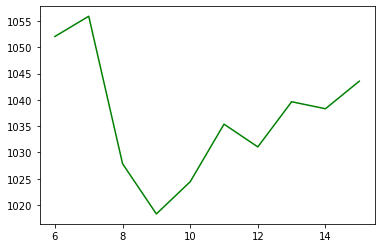

n_components with minimum perplexity: 9


In [5]:
def test_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior=0.1,
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []
    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter,
            topic_word_prior= topic_word_prior, doc_topic_prior=doc_topic_prior, 
            learning_method='batch', n_jobs= -1, random_state=7)
        lda.fit(cv)
        iter_num.append(i)
        per_value.append(lda.perplexity(cv))
    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

print("n_components with minimum perplexity:", 
      test_perplexity(review_cv, start=6, end=15))

In [6]:
lda = LatentDirichletAllocation(n_components=8, #추출할 topic의 수를 지정 max_iter=20,
                                topic_word_prior=0.1,
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs=-1,
                                random_state=7)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: graphics, image, mail, file, available, ftp, data, information, files, software
Topic #1: nasa, space, gov, orbit, ___, com, center, posting, earth, research
Topic #2: com, keith, morality, caltech, host, nntp, objective, sgi, drive, posting
Topic #3: com, article, jesus, know, just, god, don't, posting, host, nntp
Topic #4: people, god, don't, think, does, say, believe, just, like, way
Topic #5: scsi, drive, card, com, ide, bus, controller, use, bit, windows
Topic #6: space, article, access, com, posting, nntp, university, host, just, digex
Topic #7: key, encryption, clipper, chip, com, government, keys, use, security, public



In [7]:
#!pip install gensim

In [8]:
#!pip install pyldavis

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
cachedStopWords = stopwords.words("english")
RegTok = RegexpTokenizer("[\w']{3,}") # 정규포현식으로 토크나이저를 정의
english_stops = set(stopwords.words('english')) # 영어 불용어를 가져옴
def tokenizer(text):
    tokens = RegTok.tokenize(text.lower())
    # stopwords 제외
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2] 
    return words
texts = [tokenizer(news) for news in newsgroups_train.data]

In [10]:
from gensim.corpora.dictionary import Dictionary
# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))
# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n = 2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))
# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts] 
print('#Number of unique tokens: %d' % len(dictionary)) 
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 46466
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 3219


In [11]:
from gensim.models import LdaModel
num_topics = 8
passes = 5
model = LdaModel(corpus=corpus, id2word=dictionary,\
                       passes=passes, num_topics=num_topics, \
                       random_state=7)

In [12]:
model.print_topics(num_words=10)

[(0,
  '0.013*"com" + 0.012*"would" + 0.010*"article" + 0.010*"card" + 0.009*"nntp" + 0.009*"host" + 0.009*"posting" + 0.008*"system" + 0.008*"keith" + 0.008*"university"'),
 (1,
  '0.017*"god" + 0.012*"one" + 0.011*"people" + 0.009*"would" + 0.009*"jesus" + 0.008*"com" + 0.008*"say" + 0.006*"christian" + 0.006*"bible" + 0.006*"believe"'),
 (2,
  '0.031*"com" + 0.027*"posting" + 0.026*"host" + 0.026*"nntp" + 0.019*"access" + 0.015*"article" + 0.014*"university" + 0.012*"digex" + 0.010*"net" + 0.010*"cwru"'),
 (3,
  '0.032*"space" + 0.018*"nasa" + 0.010*"gov" + 0.007*"orbit" + 0.006*"research" + 0.006*"earth" + 0.006*"launch" + 0.005*"first" + 0.005*"shuttle" + 0.005*"data"'),
 (4,
  '0.015*"would" + 0.014*"people" + 0.011*"com" + 0.010*"one" + 0.008*"like" + 0.007*"get" + 0.007*"article" + 0.007*"government" + 0.007*"think" + 0.007*"right"'),
 (5,
  '0.022*"key" + 0.015*"encryption" + 0.013*"chip" + 0.013*"clipper" + 0.010*"com" + 0.009*"use" + 0.008*"keys" + 0.008*"system" + 0.007*"dr

In [13]:
 print("#topic distribution of the first document: ", model.get_document_topics(corpus)
[0])

#topic distribution of the first document:  [(0, 0.15090123), (1, 0.6031323), (6, 0.2426202)]


In [14]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
# LDA 모형을 pyLDAvis 객체에 전달
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

C:\Users\sangu\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.167620  0.042053       1        1  18.713844
5      0.068452  0.131736       2        1  16.310581
7      0.124927  0.016658       3        1  14.811461
4     -0.075573  0.033361       4        1  13.429894
3      0.107848  0.001626       5        1  12.446376
0      0.023261 -0.083507       6        1  10.405688
6     -0.084520 -0.007936       7        1   8.152190
2      0.003225 -0.133990       8        1   5.729965, topic_info=        Term         Freq        Total Category  logprob  loglift
538    space  1533.000000  1533.000000  Default  30.0000  30.0000
834      key  1300.000000  1300.000000  Default  29.0000  29.0000
20       com  3703.000000  3703.000000  Default  28.0000  28.0000
200      god  1153.000000  1153.000000  Default  27.0000  27.0000
70   posting  1732.000000  1732.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
289     like   127.889830  1663.500215   Topic8  -5.0142   0.2940
92     think   119.618152  1329.765236   Topic8  -5.0810   0.4510
116   anyone   104.015251   744.616905   Topic8  -5.2208   0.8911
304     know   101.045274  1486.391369   Topic8  -5.2498   0.1709
188     case    89.734054   514.281883   Topic8  -5.3685   1.1135

[503 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1359      2  0.081635      128
1359      3  0.854026      128
1359      4  0.018839      128
1359      5  0.037678      128
153       1  0.055294     1993
...     ...       ...      ...
704       5  0.007843      zoo
704       6  0.972586      zoo
704       8  0.007843      zoo
705       4  0.014601  zoology
705       6  0.978273  zoology

[2103 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 8, 5, 4, 1, 7, 3])